# Predicting User Churn: A Data-Driven Approach to Identifying At-Risk Customers for Interconnect. 


## Objective

To understand why Interconnect customers churn or stop services.

**Key Deliverables:**
- Data cleaning and preprocessing.
- Exploratory Data Analysis (EDA).
- Feature engineering (create additional meaningful features).
- Model development (classification models for churn prediction).
- Model evaluation (accuracy, precision, recall, F1 score, AUC-ROC, etc.).
- Final report with insights and recommendations.

**Timeline:**
Estimated time: 2-3 weeks

- Week 1: Data understanding, cleaning, and EDA.
- Week 2: Feature engineering, model training, and evaluation.
- Week 3: Final analysis and documentation.

# Proposed Work Plan

**Cleanup & Process Data:**
- First we'll clean up column names by making them all lowercase and using underscores for spacing.
- Check for missing values and fill based on column criteria
- Handle duplicates if any
- Merge the datasets into one dataframe on customer_id
- Change begin_date to datetype
- Handle column datatypes if needed
- Resample data for class imbalance
<br>

**Feature Engineering**
- Create a column for customer tenure
- Check seasonality by begin date
- Create column for number of features customer is using
<br>

**Exploratory Data Analysis**
- Explore data using visualizations to:
- detect outliers 
- check class distributions 
- look at feature relationships and correlation 
- check for possible data leakage 
- look at class imbalances 
<br>


**Model Selection & Training**
- Split data into training, validation, and test set using train_test_split. May also use stratified splitting because of the target class imbalance.
- Train different models such as Linear Regression, Decision Tree, Random Forest, and Gradient Boosting.
- Evaluate models on validation set using precision, recall, F1-score, ROC-AUC, and Average Precision Score.
- Hypertune models with oversampling and undersampling, class weights, and/or threshold tuning.
<br>

**Model Testing & Final Model Selection**
- Run best model on test data and evaluate feature importance.
<br>

**Optional** ------->> **Hypothesis Testing**
- Does payment type between month-to-month and 1 or 2 years affect customer churn?
- Does one payment method produce more churn than the other?
<br>

**Final Report**
- Produce final report and conclusion for Interconnect stakeholders.

## Clarifying Questions

- What specific method is used to define churn? Customer termination of services or non-payment?
- What is the timeline for when churn needs to be predicted? A month before churn or upon contract renewal?
- Are there early termination fees?
- What are the contract renewal periods and are they automatically renewed? 
- Have promotional items been offered before to users that were planning on leaving and if so, are those users included in our dataset?
- Do you have data on customer usage patterns?
- How frequently is data collected and updated?
- Are there any regulatory or privacy considerations when using client personal data for churn prediction?
- Would you like to see if different service types and renewal periods affect customer churn?
- Who will be the audience and users of this project? 
- When would you like the model completed by?
- How often do you need this updated? 

## Evaluation Metrics

I see that our primary evaluation metric for our model is AUC-ROC with a minimum score of 0.75 - 0.88 or above. I agree that AUC-ROC would be a great metric for evaluating user churn as it will tell us how well our model is at making predictions and it works well for imbalanced classes. 

I do not advise to use Accuracy score as an evaluation metric for this dataset since our Target class is imbalanced with only ~27% of users that have churned. When using accuracy score, our model would be biased toward the majority class of non-churners to obtain a high accuracy score but would fail to identify churners.  If we want to use an additional metric, I suggest using precision, recall, and F1-scores. 

In [844]:
# Imports
# Data manipulation
import pandas as pd
from IPython.display import display, HTML
import math
import numpy as np
from datetime import datetime
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px 


# Feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer  



# Model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit


# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve


# Utilities
import time 
import os
from sklearn.utils import resample
import scipy.stats as stats

# To suppress warnings
import warnings            
warnings.filterwarnings('ignore')

In [845]:
## Helper Functions

def camel_to_snake(camel_str):
    """
    Converts camel case string to snake case string.
    
    Parameters:
    camel_str (str): Camel case string.
    
    Returns:
    str: Snake case string.
    """
    # Use regex to insert underscores before each capital letter (except the first one) and convert to lowercase
    return re.sub(r'(?<!^)(?=[A-Z])', '_', camel_str).lower()

def standardize_column_names(df):
    """
    Converts column names from camel case to snake case.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns to be standardized.
    
    Returns:
    pd.DataFrame: DataFrame with standardized column names.
    """
    df.columns = [camel_to_snake(col) for col in df.columns]
    return df




def inspect_data(df):
    """
    Inspect the DataFrame by printing summary information, checking for duplicates,
    and identifying null values.
    
    Parameters:
    df (pd.DataFrame): DataFrame to be inspected.
    """
    
    # Print the DataFrame's shape
    print(f"DataFrame Shape: {df.shape}")
    print("\n")
    
    
    # Print general info about the DataFrame
    print("DataFrame Info:")
    print(df.info())
    print("\n")
    
    # Print the number of duplicate rows
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")
    print("\n")
    
    # Print the count of null values in each column
    null_counts = df.isna().sum()
    print("Null values in each column:")
    print(null_counts[null_counts > 0])  # Print only columns with null values
    print("\n")


In [846]:
# Load Datasets

path_1 = r"C:\Users\Rachel.Salbador\OneDrive - Priority Title & Escrow\Desktop\Final Project\final_provider\final_provider\contract.csv"
path_2 = r"C:\Users\Rachel.Salbador\OneDrive - Priority Title & Escrow\Desktop\Final Project\final_provider\final_provider\internet.csv"
path_3 = r"C:\Users\Rachel.Salbador\OneDrive - Priority Title & Escrow\Desktop\Final Project\final_provider\final_provider\personal.csv"
path_4 = r"C:\Users\Rachel.Salbador\OneDrive - Priority Title & Escrow\Desktop\Final Project\final_provider\final_provider\phone.csv"

df1 = pd.read_csv(path_1)
df2 = pd.read_csv(path_2)
df3 = pd.read_csv(path_3)
df4 = pd.read_csv(path_4)


In [847]:
# Combine the dataset heads with HTML and CSS for scrolling
display(HTML('''
<div style="max-height: 300px; overflow-y: scroll; border: 2px solid black;">
    <h3>Contract Data Head</h3>
    {0}
    <h3>Internet Data Head</h3>
    {1}
    <h3>Personal Data Head</h3>
    {2}
    <h3>Phone Data Head</h3>
    {3}
</div>
'''.format(df1.head().to_html(), 
           df2.head().to_html(), 
           df3.head().to_html(),
           df4.head().to_html())))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


-------------------------------------------------------------------------------------------------------------------------------

## 🧹 Data Preprocessing

-------------------------------------------------------------------------------------------------------------------------------

In [849]:
df1['BeginDate'].value_counts()

BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: count, Length: 77, dtype: int64

In [850]:
len(df1[df1['EndDate'] == 'No']) / len(df1['EndDate'])

0.7346301292063041

In [851]:
df1.shape

(7043, 8)

**Initial Observation Notes**
Our dataset contains 7,043 contracts from 02-01-2014 to 02-01-2020.
We can see that we have an imbalance in our classes with our Target variable showing 73% of the users have not left which would leave little for our model to train on predicting users at risk for leaving.

#### Contracts Dataset (df1)

In [854]:
df1.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [855]:
inspect_data(df1)

DataFrame Shape: (7043, 8)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


Number of duplicate rows: 0


Null values in each column:
Series([], dtype: int64)




**Contracts (df1) Dataset Preprocessing Tasks**
<br>
- Change all column names to lowercase and use underscores for spacing
- Convert BeginDate column to datetime
- Encode 'Type', 'PaperlessBilling', and 'PaymentMethod' using One Hot Encoding
- Convert 'Total Charges' to numeric data type
- Convert 'Enddate' to datetime and create target variable. Replace 'No' with NaT > convert to datetime > create 'churned' column from 'enddate' using notna().
- No duplicated entries
- No missing values
<br>

**Feature Engineering**
- replace 'no' with NaT in 'end_date' column
- convert 'end_date' to datetime
- create 'contract_duration_days' column

<br>

#### Internet Dataset (df2)

In [859]:
df2.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [860]:
inspect_data(df2)

DataFrame Shape: (5517, 8)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


Number of duplicate rows: 0


Null values in each column:
Series([], dtype: int64)




In [861]:
df2['InternetService'].value_counts()

InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

**Notes on Internet(df2) Dataset**
<br>
- Change column names to lowercase with underscores
- Convert binary columns to numeric
- There are no duplicate entries and no missing values.

We will keep the columns as is for merging.

<br>

#### Personal Dataset (df3)

In [865]:
df3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [866]:
inspect_data(df3)

DataFrame Shape: (7043, 5)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


Number of duplicate rows: 0


Null values in each column:
Series([], dtype: int64)




**Notes on Personal Dataset(df3)**
<br>
- Change column names to lowercase with underscores
- Convert binary columns to numeric
- No duplicate entries
- No missing values

<br>

#### Phone Data (df4)

In [870]:
df4.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [871]:
inspect_data(df4)

DataFrame Shape: (6361, 2)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


Number of duplicate rows: 0


Null values in each column:
Series([], dtype: int64)




**Notes on Phone Dataset(df4)**
- Column names
- Convert binary columns to numeric
- No duplicate entries or missing values

We will leave as is for merging.

<br>

#### Merge Datasets

In [875]:
# Merge 4 datasets into 1 dataset on 'customerID' column using 'outer' merge to ensure we capture all customerIDs in each dataset
merged_df = pd.merge(df1, df2, on='customerID', how='outer')
merged_df = pd.merge(merged_df, df3, on='customerID', how='outer')
merged_df = pd.merge(merged_df, df4, on='customerID', how='outer')

In [876]:
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [877]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


Our datasets are successfully merged into one. Now we will preprocess the data and add new columns.

#### Preprocessing & Feature Engineering

In [880]:
# Correct column names to lowercase and underscores
standardize_column_names(merged_df)
merged_df = merged_df.rename(columns={'customer_i_d': 'customer_id', 'streaming_t_v': 'streaming_tv'})
merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [881]:
# convert begin_date column to datetime
merged_df['begin_date'] = pd.to_datetime(merged_df['begin_date'])

**To prevent our models from having too many features and possibly overfitting, I will categorize each customer into groups by service type. This makes sense as most businesses group their customers by service type and will help us analyze data for each group.**

In [883]:
# categorize customer by service type
def categorize_service(row):
    if pd.notna(row['internet_service']) and pd.notna(row['multiple_lines']):
        return 'Both'
    elif pd.notna(row['internet_service']):
        return 'Internet only'
    elif pd.notna(row['multiple_lines']):
        return 'Phone only'
    else:
        return 'No service'
    
merged_df['service_type'] = merged_df.apply(categorize_service, axis=1)

In [884]:
merged_df['service_type'].value_counts()

service_type
Both             4835
Phone only       1526
Internet only     682
Name: count, dtype: int64

The numbers make sense. Now we will fill in missing values of our dataset.

In [886]:
# Fill NaN's in 'multiple_lines' column with 'No phone service'
merged_df['multiple_lines'].fillna('No phone service', inplace=True)

In [887]:
# Fill NaN's in internet services with 'no internet services'
merged_df.fillna('no internet services', inplace=True)

In [888]:
# Ensure all NaN values are filled
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

In [889]:
# check value counts to ensure column filled correctly
merged_df['internet_service'].value_counts()

internet_service
Fiber optic             3096
DSL                     2421
no internet services    1526
Name: count, dtype: int64

All of our missing values have been filled to indicate no phone service or no internet service for that customer and the numbers match our splits.

Now we will create our Target column 'churned' as a binary classification column. I will use the 'end_date' column to replace the No with NaT (not a time) to label customers who have not churned and to be able to convert our 'end_date' column to datetime in order to create a new feature columns. 

In [892]:
# Replace 'No' with 'NaT' in 'end_date' column
merged_df['end_date'] = merged_df['end_date'].replace('No', pd.NaT)

In [893]:
# Convert 'end_date' column to datetime
merged_df['end_date'] = pd.to_datetime(merged_df['end_date'], errors='coerce')

In [894]:
# Create churned column
merged_df['churned'] = merged_df['end_date'].notna().astype(int)

In [895]:
# Create 'contract_duration_days' column
merged_df['contract_duration_days'] = (merged_df['end_date'].fillna(pd.Timestamp('2020-12-31')) - merged_df['begin_date']).dt.days

In [896]:
# Create tenure_months column
merged_df['tenure_months'] = (merged_df['end_date'] - merged_df['begin_date']).dt.days/30

In [897]:
merged_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,service_type,churned,contract_duration_days,tenure_months
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,Female,0,Yes,No,No phone service,Internet only,0,365,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,No,Male,0,No,No,No,Both,0,1370,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,Male,0,No,No,No,Both,1,61,2.033333
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,No,Male,0,No,No,No phone service,Internet only,0,1705,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,Female,0,No,No,No,Both,1,61,2.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Male,0,Yes,Yes,Yes,Both,0,1064,NaN
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,Yes,Female,0,Yes,Yes,Yes,Both,0,2525,NaN
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,Female,0,Yes,Yes,No phone service,Internet only,0,671,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,Male,1,Yes,No,Yes,Both,1,123,4.100000


Now we have our Target column and new columns 'contract_duration_days' and 'tenure_months'.

Now we will convert our monetary columns to numeric value to do some exploratory data analysis.

In [899]:
merged_df['monthly_charges'] = pd.to_numeric(merged_df['monthly_charges'], errors='coerce')

In [900]:
merged_df['total_charges'] = pd.to_numeric(merged_df['total_charges'], errors='coerce')

In [901]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7043 non-null   object        
 1   begin_date              7043 non-null   datetime64[ns]
 2   end_date                1869 non-null   datetime64[ns]
 3   type                    7043 non-null   object        
 4   paperless_billing       7043 non-null   object        
 5   payment_method          7043 non-null   object        
 6   monthly_charges         7043 non-null   float64       
 7   total_charges           7032 non-null   float64       
 8   internet_service        7043 non-null   object        
 9   online_security         7043 non-null   object        
 10  online_backup           7043 non-null   object        
 11  device_protection       7043 non-null   object        
 12  tech_support            7043 non-null   object  

After converting our numeric columns to numeric data type, we got NaN values in the total_charges column. Let's check these and see what is going on. 

In [903]:
missing_total_charges = merged_df[merged_df['total_charges'].isna()]
print(missing_total_charges[['customer_id', 'total_charges']])

     customer_id  total_charges
488   4472-LVYGI            NaN
753   3115-CZMZD            NaN
936   5709-LVOEQ            NaN
1082  4367-NUYAO            NaN
1340  1371-DWPAZ            NaN
3331  7644-OMVMY            NaN
3826  3213-VVOLG            NaN
4380  2520-SGTTA            NaN
5218  2923-ARZLG            NaN
6670  4075-WKNIU            NaN
6754  2775-SEFEE            NaN


In [904]:
# Create list of customer IDs to check
customer_ids = ['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ', '4367-NUYAO', 
                '1371-DWPAZ', '7644-OMVMY', '3213-VVOLG', '2520-SGTTA', 
                '2923-ARZLG', '4075-WKNIU', '2775-SEFEE']

# Filter the DataFrame to get rows where customer_id is in the list
filtered_customers = merged_df[merged_df['customer_id'].isin(customer_ids)]


print(filtered_customers)

     customer_id begin_date end_date      type paperless_billing  \
488   4472-LVYGI 2020-02-01      NaT  Two year               Yes   
753   3115-CZMZD 2020-02-01      NaT  Two year                No   
936   5709-LVOEQ 2020-02-01      NaT  Two year                No   
1082  4367-NUYAO 2020-02-01      NaT  Two year                No   
1340  1371-DWPAZ 2020-02-01      NaT  Two year                No   
3331  7644-OMVMY 2020-02-01      NaT  Two year                No   
3826  3213-VVOLG 2020-02-01      NaT  Two year                No   
4380  2520-SGTTA 2020-02-01      NaT  Two year                No   
5218  2923-ARZLG 2020-02-01      NaT  One year               Yes   
6670  4075-WKNIU 2020-02-01      NaT  Two year                No   
6754  2775-SEFEE 2020-02-01      NaT  Two year               Yes   

                 payment_method  monthly_charges  total_charges  \
488   Bank transfer (automatic)            52.55            NaN   
753                Mailed check            20.25 

So it turns out the customers with no values in the total_charges column are the 11 new customers that signed up on 02/01/2020 when our data was pulled for analysis. Therefore they do not have total charges yet. We will fill those values with their monthly_charges amount since that is all they have. 

In [906]:
# For rows where total_charges is NaN, fill it with the corresponding monthly_charges
merged_df['total_charges'].fillna(merged_df['monthly_charges'], inplace=True)

In [907]:
merged_df['total_charges'].isna().sum()

0

**Preprocessing Summary**
- Checked each dataset for duplicate and missing values ensuring there were none.
- Merged datasets into one dataset.
- Corrected column names to lowercase and underscores
- Changed date columns to datetime format
- Created categories of customers based on service type
- Filled in missing values
- Created binary classification target column 'churned'
- Created 'contract_duration_days' column 
- Created 'tenure_months' column
- Changed numeric columns to numeric data type

<br>

-------------------------------------------------------------------------------------------------------------------------------

##  📊 Exploratory Data Analysis
<br>
Visualize churn patterns, analyze features like monthly charges, and examine customer demographics. Explore how different features affect churn in our dataset. 

-------------------------------------------------------------------------------------------------------------------------------

**Churn Across Service Type**

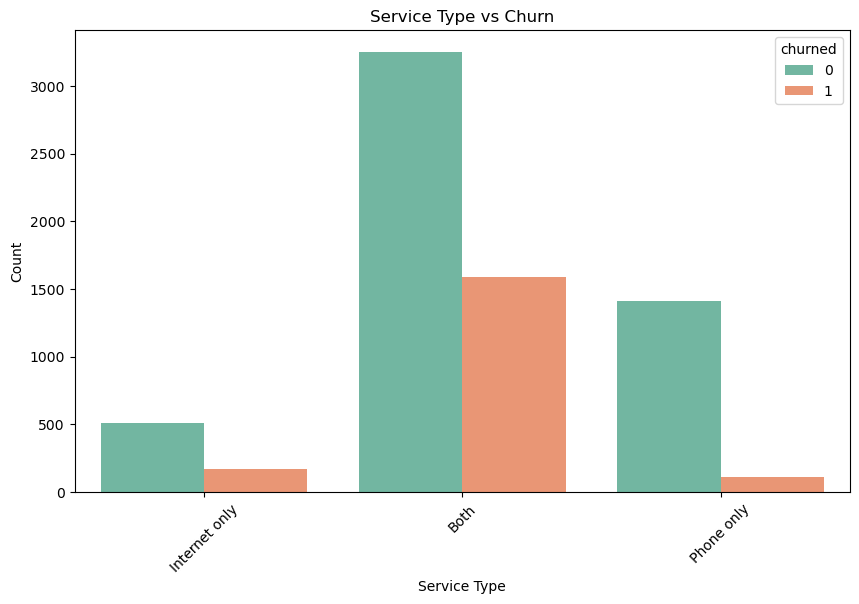

In [912]:
# Bar Chart to show distribution of churn across different service types
plt.figure(figsize=(10, 6))
sns.countplot(x='service_type', hue='churned', data=merged_df, palette='Set2')
plt.title('Service Type vs Churn')
plt.xlabel('Service Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show() 

Most of our churned customers were using both internet and phone services. Phone only customers have the lowest churn rate and internet only customers about 1/3 of them churn. Let's take a look at demographics and churn rate.

**Churn & Demographic**

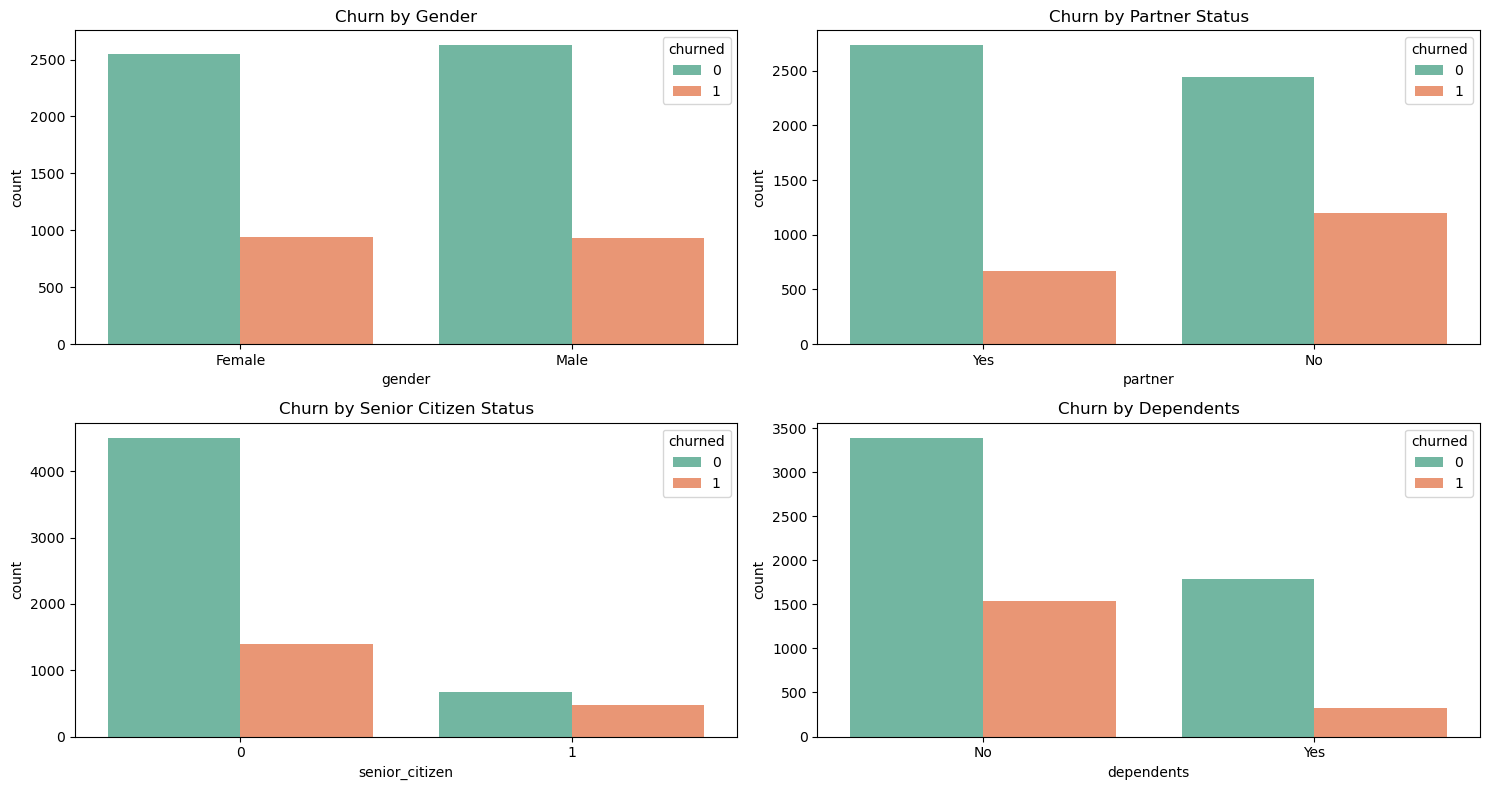

In [915]:
plt.figure(figsize=(15, 8))

# Gender vs Churn
plt.subplot(2, 2, 1)
sns.countplot(x='gender', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Gender')

# Partner vs Churn
plt.subplot(2, 2, 2)
sns.countplot(x='partner', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Partner Status')

# Senior Citizen vs Churn
plt.subplot(2, 2, 3)
sns.countplot(x='senior_citizen', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Senior Citizen Status')

# Dependents vs Churn
plt.subplot(2, 2, 4)
sns.countplot(x='dependents', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Dependents')

plt.tight_layout()
plt.show()

Based on gender, the churn rate is nearly 50/50 so that isn't a factor. What we can tell is that more single customers without dependents have higher churn compared to those who have partners and dependents. 

Now let's take a look at how payment choices affect churn.

**Churn vs Billing**

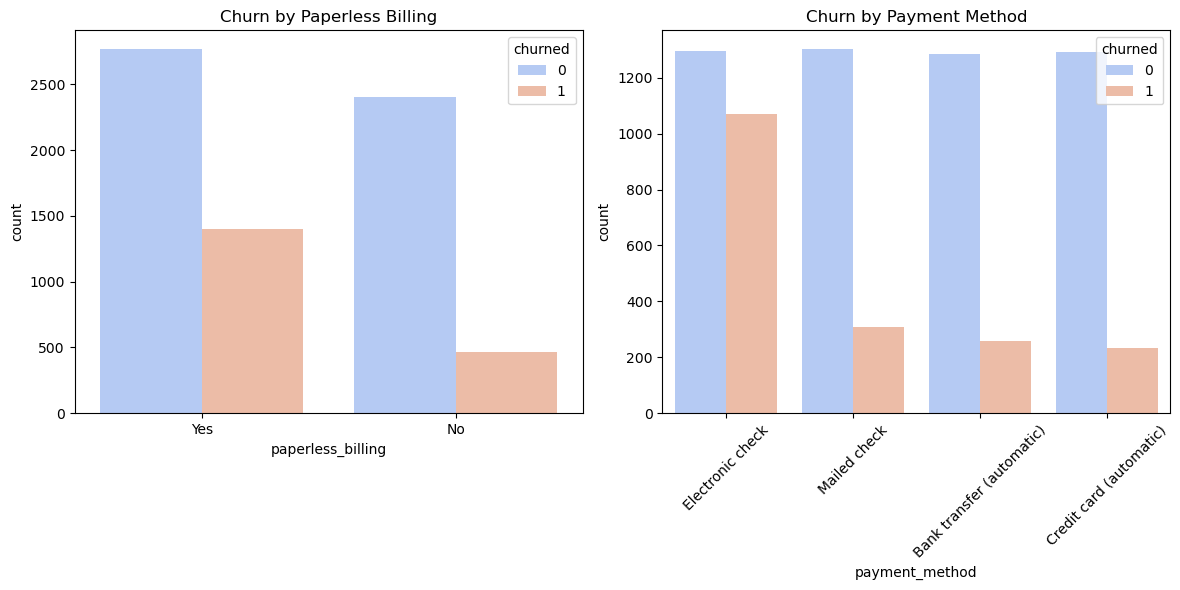

In [918]:
plt.figure(figsize=(12, 6))

# Paperless Billing vs Churn
plt.subplot(1, 2, 1)
sns.countplot(x='paperless_billing', hue='churned', data=merged_df, palette='coolwarm')
plt.title('Churn by Paperless Billing')

# Payment Method vs Churn
plt.subplot(1, 2, 2)
sns.countplot(x='payment_method', hue='churned', data=merged_df, palette='coolwarm')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We have a very high rate of churned with electronic check type payment method compared to all other methods. Also, more customers enrolled in paperless billing have churned compared to those that receive a bill by mail.

**Churn by Contract Type**
<br>
Explore how contract duration impacts customer churn.

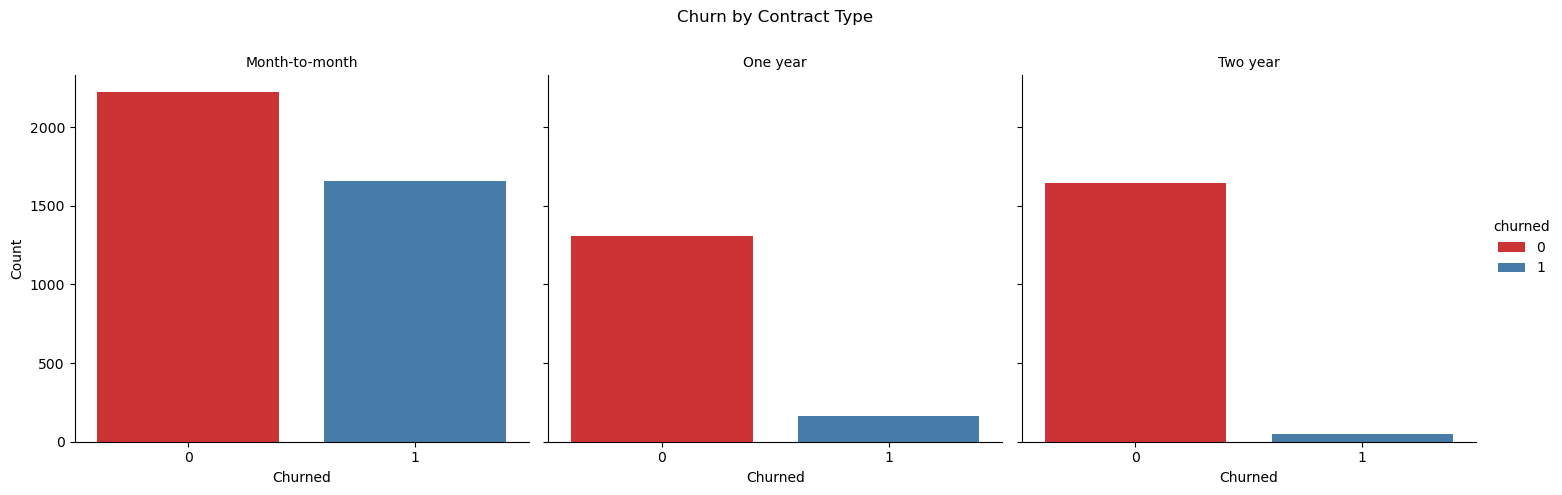

In [921]:
g = sns.FacetGrid(merged_df, col="type", hue="churned", palette="Set1", height=5, aspect=1)
g.map(sns.countplot, "churned", order=[0, 1])
g.add_legend()
g.set_axis_labels("Churned", "Count")
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Churn by Contract Type')
plt.show()

We can see a huge amount of our churned customers were enrolled in month-to-month plans versus yearly plans.

**Churn & Date Features**
<br>
Analyze how long customers stay before they churn.

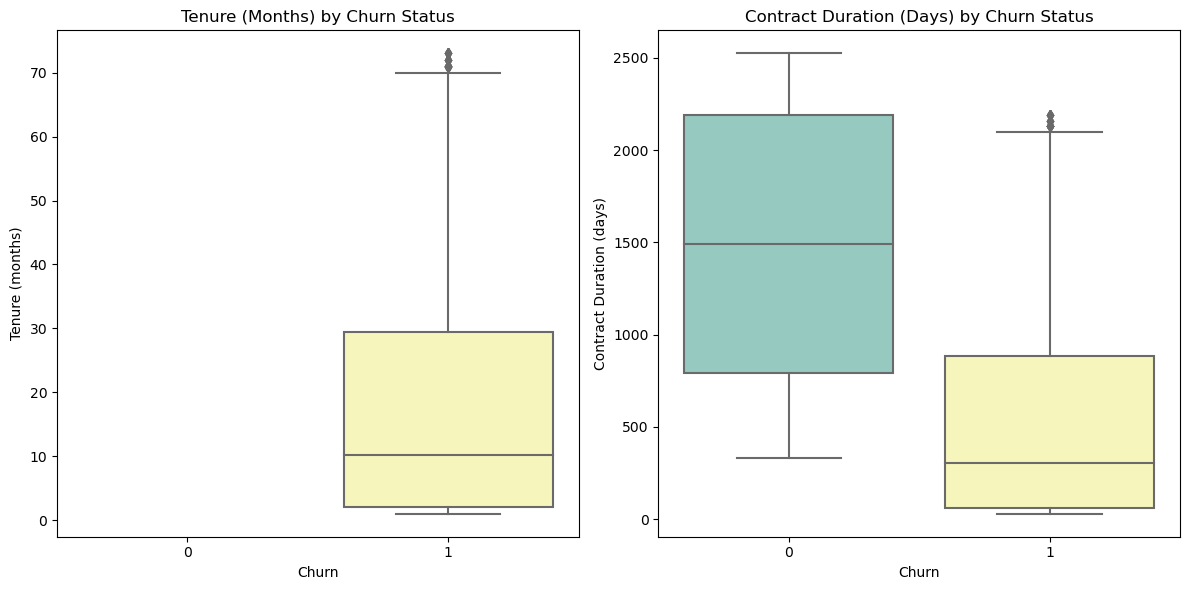

In [924]:
plt.figure(figsize=(12, 6))

# Tenure (Months) vs Churn
plt.subplot(1, 2, 1)
sns.boxplot(x='churned', y='tenure_months', data=merged_df, palette='Set3')
plt.title('Tenure (Months) by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')

# Contract Duration (Days) vs Churn
plt.subplot(1, 2, 2)
sns.boxplot(x='churned', y='contract_duration_days', data=merged_df, palette='Set3')
plt.title('Contract Duration (Days) by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Contract Duration (days)')

plt.tight_layout()
plt.show()

It appears the median of our customers churn around 10 months or approximately 300 days. Most stay for about 2.5 years and then churn. Non churned customers typical contract length is between 2.5 - 5.5 years.

**Churn & Additional Services**
Investigate how service subscriptions influence churn

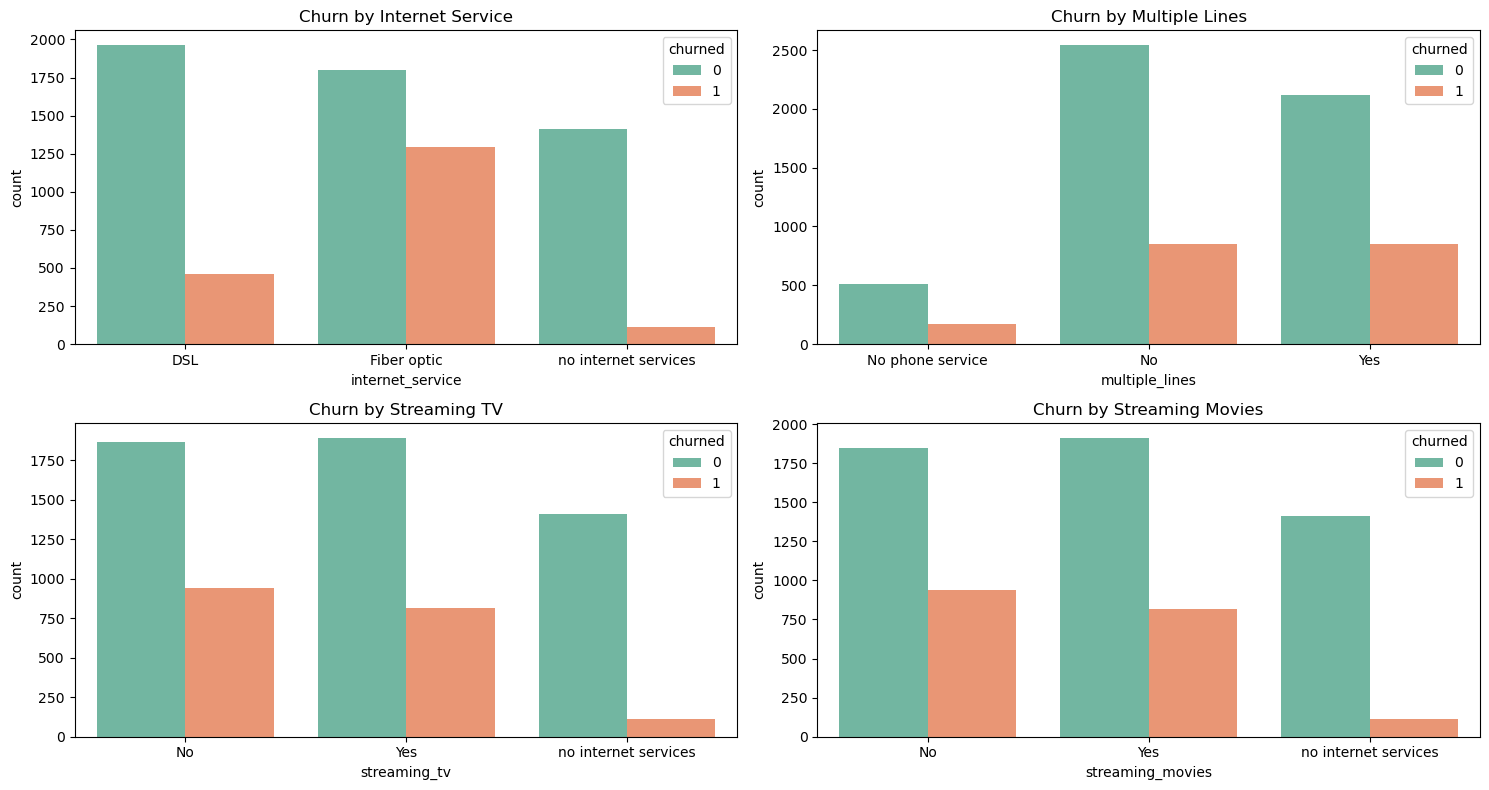

In [927]:
plt.figure(figsize=(15, 8))

# Internet Service vs Churn
plt.subplot(2, 2, 1)
sns.countplot(x='internet_service', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Internet Service')

# Multiple Lines vs Churn
plt.subplot(2, 2, 2)
sns.countplot(x='multiple_lines', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Multiple Lines')

# Streaming TV vs Churn
plt.subplot(2, 2, 3)
sns.countplot(x='streaming_tv', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Streaming TV')

# Streaming Movies vs Churn
plt.subplot(2, 2, 4)
sns.countplot(x='streaming_movies', hue='churned', data=merged_df, palette='Set2')
plt.title('Churn by Streaming Movies')


plt.tight_layout()
plt.show()

Looking at churn based on optional services the only one that shows some differences is the internet service. We can see that customrs with Fiber Optic internet have a higher churn rate compared to those with DSL or no internet service.

**Churn and Charges**

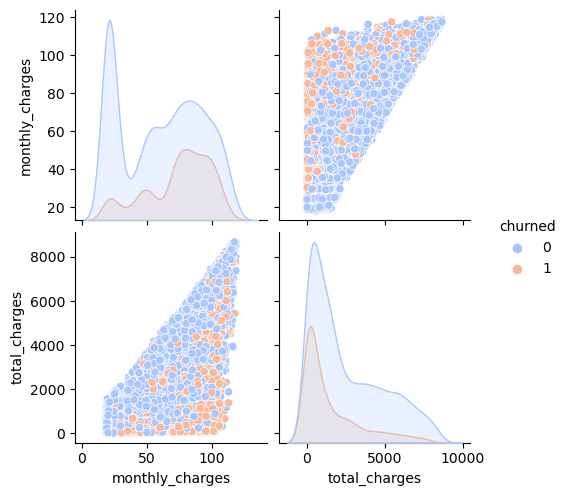

In [930]:
sns.pairplot(merged_df, hue='churned', vars=['monthly_charges', 'total_charges'], palette='coolwarm', diag_kind='kde')
plt.show()

We can see more churn with higher monthly charges and higher total charges.

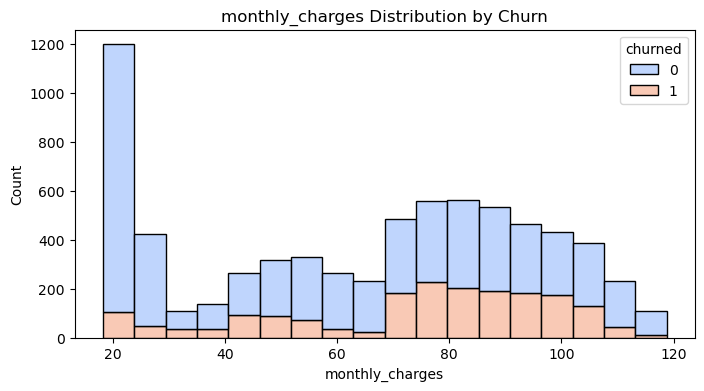

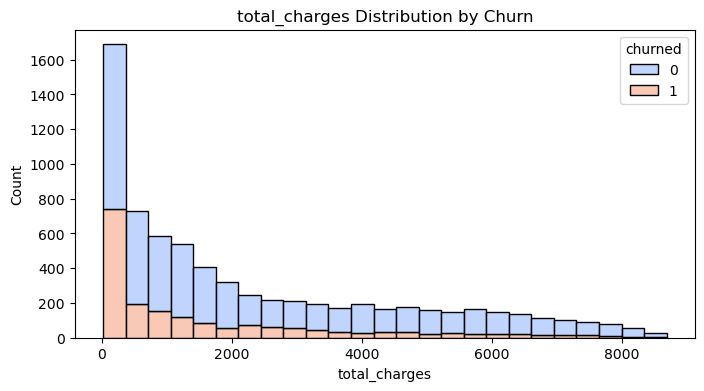

In [932]:
# Plot histograms for numeric features based on churn status
num_features = ['monthly_charges', 'total_charges']

for feature in num_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=merged_df, x=feature, hue='churned', multiple='stack', palette='coolwarm')
    plt.title(f'{feature} Distribution by Churn')
    plt.xlabel(f'{feature}')
    plt.ylabel('Count')
    plt.show()

There's slight correlation with higher monthly charges and higher churn rate and we can definitely see the class imbalance between churned and not churned customers with this Histogram. 

**Churn and Internet Support/Security**

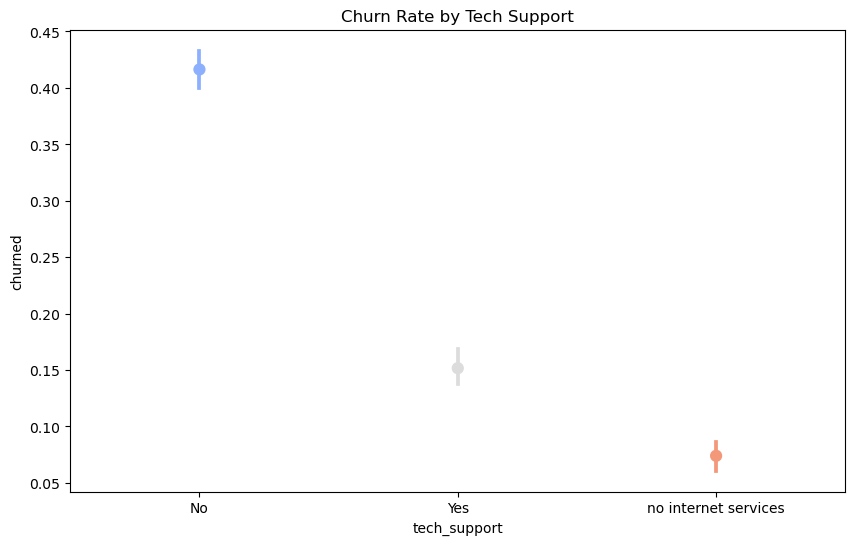

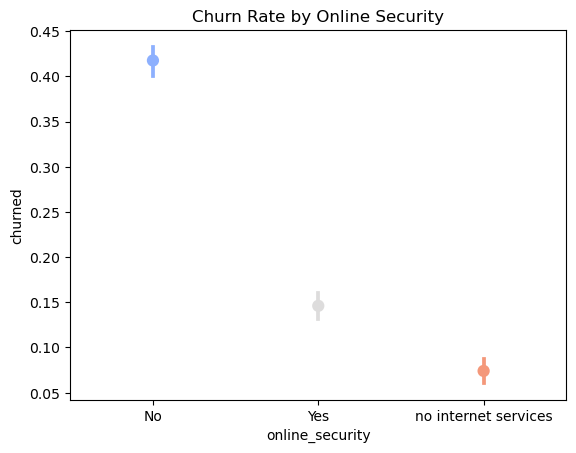

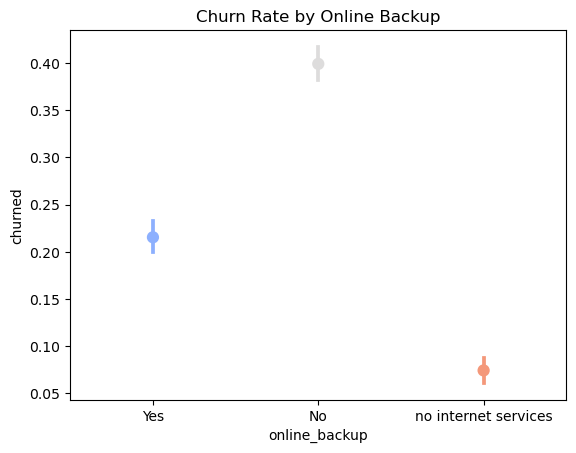

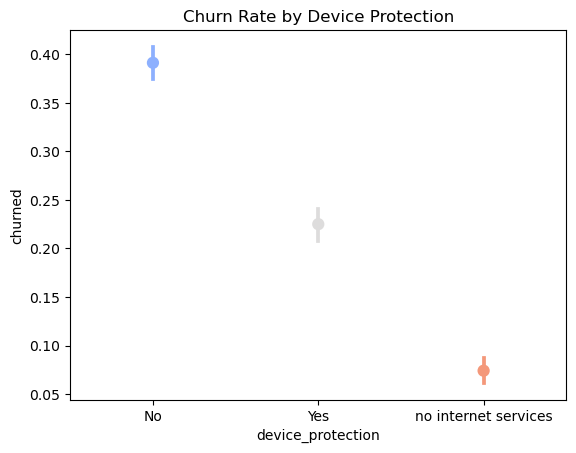

In [935]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='tech_support', y='churned', data=merged_df, palette='coolwarm')
plt.title('Churn Rate by Tech Support')
plt.show()

sns.pointplot(x='online_security', y='churned', data=merged_df, palette='coolwarm')
plt.title('Churn Rate by Online Security')
plt.show()

sns.pointplot(x='online_backup', y='churned', data=merged_df, palette='coolwarm')
plt.title('Churn Rate by Online Backup')
plt.show()

sns.pointplot(x='device_protection', y='churned', data=merged_df, palette='coolwarm')
plt.title('Churn Rate by Device Protection')
plt.show()

We can see a correlation between churners and internet security/support. Those that did not have tech support, device protection, online security, and online backup are much more likely to churn compared to customers that have online support.

**Churn vs Begin Dates & End Dates**
<br>
Now we'll look at how contract start dates and end dates correlate with churn. We'll take a look at 2 types of charts and draw conclusions at the end.

In [938]:
# Extract the month from begin_date
merged_df['begin_month'] = merged_df['begin_date'].dt.month

# Filter rows where end_date is not null
churned_customers = merged_df[merged_df['end_date'].notnull()]

# Group by begin_month to get churn counts and average tenure
churn_data = churned_customers.groupby('begin_month').agg(
    churn_count=('customer_id', 'count'),
    avg_tenure=('tenure_months', 'mean')
).reset_index()

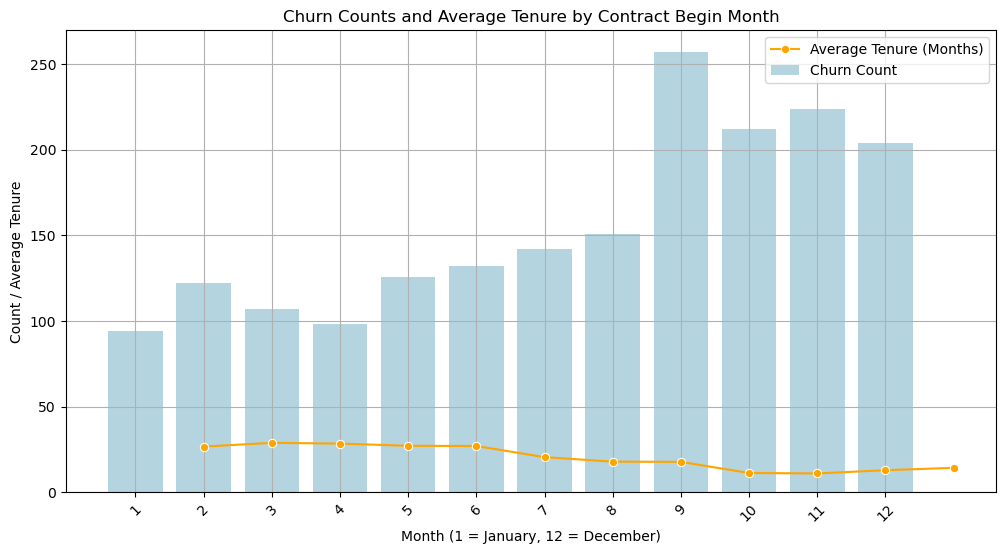

In [939]:
# Plot the bar graph
plt.figure(figsize=(12, 6))

sns.barplot(x='begin_month', y='churn_count', data=churn_data, color='lightblue', label='Churn Count')

# Create a line plot for average tenure
sns.lineplot(x='begin_month', y='avg_tenure', data=churn_data, color='orange', marker='o', label='Average Tenure (Months)')

plt.title('Churn Counts and Average Tenure by Contract Begin Month')
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('Count / Average Tenure')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

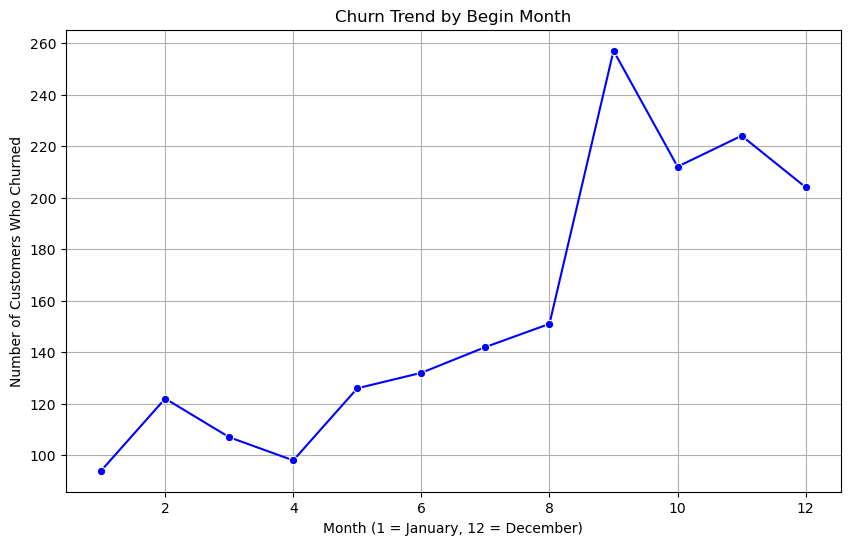

In [940]:
# Line plot visual
churner_begin_months = churned_customers['begin_month'].value_counts().sort_index()

# Plot the churn trend using a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=churner_begin_months.index, y=churner_begin_months.values, marker='o', color='blue')
plt.title('Churn Trend by Begin Month')
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('Number of Customers Who Churned')
plt.grid(True)
plt.show()

We can see that customers that signed up in the months of September through December have the highest churn rate and the lowest tenure months. Customers that sign up in January and April have the lowest churn rates. 
<br>
Now let's take a look at when most customers churn.

**End Date Months & Churn**

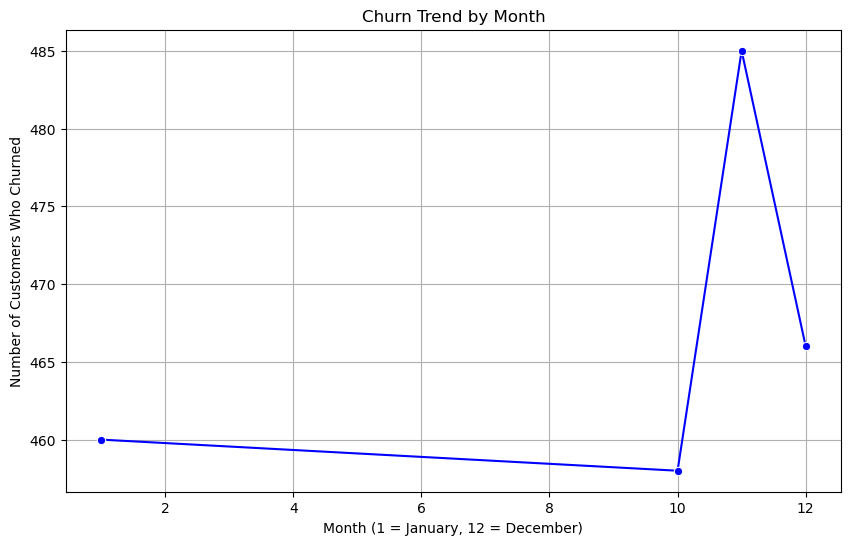

In [943]:
# Extract the month from end_date
merged_df['churn_month'] = merged_df['end_date'].dt.month

# Filter rows where end_date is not null (i.e., customers who churned)
churned_customers = merged_df[merged_df['end_date'].notnull()]

monthly_churn = churned_customers['churn_month'].value_counts().sort_index()

# Plot the churn trend using a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_churn.index, y=monthly_churn.values, marker='o', color='blue')
plt.title('Churn Trend by Month')
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('Number of Customers Who Churned')
plt.grid(True)
plt.show()

Interesting, we have a spike in customers churning in the month of November. Perhaps there's seasonality in our data since we have the highest number of churn in the later months of the year.

**EDA Summary:**
- Phone only customers have the lowest churn rate
- Internet only customers about 1/3 of them churn compared to non-churners.
- Customers using both services, about 45% of them churn compared to non-churn.
- Single customers with no dependendts are more likely to churn compared to customers who have partners and dependents.
- Customers enrolled in paperless billing and who pay by electronic check have higher churn rating compared to other billing and payment methods.
- Customers with Fiber Optic internet versus DSL have a higher churn probability.
- Customers with monthly charges between $75 - $105 dollars are more frequent churners.
- Customers without tech support, online backup, security and device protection are more likely to churn compared to customers that receive those services.
- Most churners are those that signed up in September and other winter months. 
- Contract holders who begin their contracts in January churn the least.
- Most customers end their contracts in the month of November. 

-------------------------------------------------------------------------------------------------------------------------------

## 🔮 Model Creation 

-------------------------------------------------------------------------------------------------------------------------------

**Process Data for Training**

In [948]:
merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,senior_citizen,partner,dependents,multiple_lines,service_type,churned,contract_duration_days,tenure_months,begin_month,churn_month
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,0,Yes,No,No phone service,Internet only,0,365,NaN,1,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,0,No,No,No,Both,0,1370,NaN,4,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,0,No,No,No,Both,1,61,2.033333,10,12.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,0,No,No,No phone service,Internet only,0,1705,NaN,5,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,0,No,No,No,Both,1,61,2.033333,9,11.0


In [949]:
# drop customer_id and date columns, tenure_months, churn_month, and contract_duration_days columns
merged_df = merged_df.drop(columns=['customer_id', 'begin_date', 'end_date', 'tenure_months', 'churn_month', 'contract_duration_days'], axis=1)

In [950]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   internet_service   7043 non-null   object 
 6   online_security    7043 non-null   object 
 7   online_backup      7043 non-null   object 
 8   device_protection  7043 non-null   object 
 9   tech_support       7043 non-null   object 
 10  streaming_tv       7043 non-null   object 
 11  streaming_movies   7043 non-null   object 
 12  gender             7043 non-null   object 
 13  senior_citizen     7043 non-null   int64  
 14  partner            7043 non-null   object 
 15  dependents         7043 non-null   object 
 16  multiple_lines     7043 

<br>

**Encode Data**

In [953]:
# Encode ordinal features with Label Encoder
label_encoder = LabelEncoder()

for col in ['gender', 'partner', 'dependents', 'paperless_billing']:
    merged_df[col] = label_encoder.fit_transform(merged_df[col])

In [954]:
merged_df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,service_type,churned,begin_month
0,Month-to-month,1,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,0,0,1,0,No phone service,Internet only,0,1
1,One year,0,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,1,0,0,0,No,Both,0,4
2,Month-to-month,1,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,1,0,0,0,No,Both,1,10
3,One year,0,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,1,0,0,0,No phone service,Internet only,0,5
4,Month-to-month,1,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,0,0,0,0,No,Both,1,9


In [955]:
# Apply One Hot Encoding to columns with multiple categories
merged_df = pd.get_dummies(merged_df, columns=['type', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'service_type'], drop_first=True)

In [956]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       7043 non-null   int32  
 1   monthly_charges                         7043 non-null   float64
 2   total_charges                           7043 non-null   float64
 3   gender                                  7043 non-null   int32  
 4   senior_citizen                          7043 non-null   int64  
 5   partner                                 7043 non-null   int32  
 6   dependents                              7043 non-null   int32  
 7   churned                                 7043 non-null   int32  
 8   begin_month                             7043 non-null   int32  
 9   type_One year                           7043 non-null   bool   
 10  type_Two year                           7043 non-null   bool

In [957]:
# convert boolean columns to numeric (0,1)
bool_columns = merged_df.select_dtypes(include=['bool']).columns

# Convert those columns to int (0 and 1)
merged_df[bool_columns] = merged_df[bool_columns].astype(int)

In [958]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       7043 non-null   int32  
 1   monthly_charges                         7043 non-null   float64
 2   total_charges                           7043 non-null   float64
 3   gender                                  7043 non-null   int32  
 4   senior_citizen                          7043 non-null   int64  
 5   partner                                 7043 non-null   int32  
 6   dependents                              7043 non-null   int32  
 7   churned                                 7043 non-null   int32  
 8   begin_month                             7043 non-null   int32  
 9   type_One year                           7043 non-null   int32  
 10  type_Two year                           7043 non-null   int3

<br>

**Split Data into Training, Validation, and Test Sets**<br>
Since our target class is imbalanced, we'll use the stratified shuffle split to maintain class distribution across the splits.

In [961]:
# Declare feature and target variables
x = merged_df.drop(columns=['churned'], axis=1)
y = merged_df['churned']

In [962]:
# Create splitter
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split into training&validation and test sets
for train_idx, test_idx in strat_split.split(x, y):
    x_train_val, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [963]:
# Split furtherinto training and validation sets
strat_split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_idx, val_idx in strat_split_val.split(x_train_val, y_train_val):
    x_train, x_val = x_train_val.iloc[train_idx], x_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

In [964]:
print(y_train.value_counts())
print(y_val.value_counts())

churned
0    3104
1    1121
Name: count, dtype: int64
churned
0    1035
1     374
Name: count, dtype: int64


<br>

**Model Training**

Now that our data is split we will start model training. First I am going to train and evaluate the models with the stratified split as is, not adjusting for class imbalance to see what kind of F1, Precision-Recall, and ROC AUC scores we get. Then we'll implement some upsampling, downsampling, class weights, and hyperparameter tuning to help balance the minority class and see if our scores improve. Whichever model has the best scores will move onto the test data. 


In [968]:
# Unbalanced model training

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

trained_models = {}
for model_name, model in models.items():
    model.fit(x_train, y_train)
    trained_models[model_name] = model


results = {}
for model_name, model in trained_models.items():
    y_val_pred = model.predict(x_val)
    y_val_pred_proba = model.predict_proba(x_val)[:, 1]

    
    # Calculate evaluation metrics
    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    
    results[model_name] = {
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Roc Auc': roc_auc
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     F1 Score  Precision    Recall   Roc Auc
Logistic Regression  0.577444   0.659794  0.513369  0.830063
Decision Tree        0.635538   0.617128  0.655080  0.754110
Random Forest        0.624615   0.735507  0.542781  0.857847
Gradient Boosting    0.638168   0.743772  0.558824  0.872105


**Unbalanced Results Observations:**
- With relatively low F1 Scores we can see that our models struggle with the class imbalance. 
- The precision and recall scores suggest that our models are good at predicting non-churners but struggle with the churning class. 
- Gradient Boosting has the best Roc Auc score of 0.87 suggesting the model is reasonable at discriminating between both classes. 

<br> 

**Class Weights** <br>
We will go ahead and balance the class weights and run the models again to try and improve the scores.

In [971]:
# Using class weights
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

trained_models = {}
for model_name, model in models.items():
    model.fit(x_train, y_train)
    trained_models[model_name] = model


results = {}
for model_name, model in trained_models.items():
    y_val_pred = model.predict(x_val)
    y_val_pred_proba = model.predict_proba(x_val)[:, 1]

    
    # Calculate evaluation metrics
    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    
    results[model_name] = {
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Roc Auc': roc_auc
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     F1 Score  Precision    Recall   Roc Auc
Logistic Regression  0.617521   0.514235  0.772727  0.832026
Decision Tree        0.641910   0.636842  0.647059  0.756863
Random Forest        0.613707   0.735075  0.526738  0.854042
Gradient Boosting    0.638168   0.743772  0.558824  0.872069


**Class Weights Balanced Results Observations:**

- For our LR model, the Recall score increased significantly from (0.51) to (0.77) suggesting it is better at identifying churned customers. However, the precision score dropped, indicating more false positives and Roc Auc is not as high as we'd like it. 
- Decision Tree, Random Forest, and Gradient Boosting models perform slightly better when balancing class weights with higher Roc Auc scores but recall could be better. 
<br>

It will benefit us to try some more hypertuning and resampling to better identify churn patterns.


<br>

**Upsample Minority Class (churned) Instances**

In [975]:
# Resampling Data with minority class upsampled

# Over-sampling the minority class
minority_class = merged_df[merged_df['churned'] == 1]
majority_class = merged_df[merged_df['churned'] == 0]

# Resample minority class
minority_upsampled = minority_class.sample(len(majority_class), replace=True, random_state=42)

# Combine majority and upsampled minority
balanced_df = pd.concat([majority_class, minority_upsampled])

# Separate features and target
x_balanced = balanced_df.drop('churned', axis=1)
y_balanced = balanced_df['churned']

In [976]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10348 entries, 0 to 5759
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       10348 non-null  int32  
 1   monthly_charges                         10348 non-null  float64
 2   total_charges                           10348 non-null  float64
 3   gender                                  10348 non-null  int32  
 4   senior_citizen                          10348 non-null  int64  
 5   partner                                 10348 non-null  int32  
 6   dependents                              10348 non-null  int32  
 7   churned                                 10348 non-null  int32  
 8   begin_month                             10348 non-null  int32  
 9   type_One year                           10348 non-null  int32  
 10  type_Two year                           10348 non-null  int32  


In [977]:
balanced_df['churned'].value_counts()

churned
0    5174
1    5174
Name: count, dtype: int64

In [978]:
# Minority Upsampled / Classes balanced

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

trained_models = {}
for model_name, model in models.items():
    model.fit(x_balanced, y_balanced)
    trained_models[model_name] = model


results = {}
for model_name, model in trained_models.items():
    y_val_pred = model.predict(x_val)
    y_val_pred_proba = model.predict_proba(x_val)[:, 1]

    
    # Calculate evaluation metrics
    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    
    results[model_name] = {
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Roc Auc': roc_auc
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     F1 Score  Precision    Recall   Roc Auc
Logistic Regression  0.615058   0.509666  0.775401  0.832959
Decision Tree        0.979536   1.000000  0.959893  0.979947
Random Forest        0.987821   1.000000  0.975936  0.993557
Gradient Boosting    0.694476   0.600390  0.823529  0.904746


**Upsampled Minority Class Observations:**
- All of our models have improved significantly showing that increasing churned customers allows the models to make more accurate predictions in identifying these customers. However, with precision scores of 1.00 and others close to 1, we have to account for possible overfitting to the minority class and therefore less reliable models.

<br>

**Downsample Majority Class** <br>
Let's do the opposite now and downsample our majority class (non-churn) and see how our models perform. 

In [985]:
# Resampling with majority class downsampled

# Combine the training data back into a single DataFrame
train_df = pd.concat([x_train, y_train], axis=1)

# Separate majority and minority classes
majority_class_df = train_df[train_df['churned'] == 0]
minority_class_df = train_df[train_df['churned'] == 1]

# Downsample majority class
majority_downsampled = resample(majority_class_df,
                                 replace=False,  # sample without replacement
                                 n_samples=len(minority_class_df),  # to match minority class
                                 random_state=42)  

# Combine minority class with downsampled majority class
balanced_df = pd.concat([majority_downsampled, minority_class_df])

# Separate features and target
y_balanced = balanced_df['churned']
x_balanced = balanced_df.drop('churned', axis=1)

In [986]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 2312 to 6352
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   paperless_billing                       4225 non-null   int32  
 1   monthly_charges                         4225 non-null   float64
 2   total_charges                           4225 non-null   float64
 3   gender                                  4225 non-null   int32  
 4   senior_citizen                          4225 non-null   int64  
 5   partner                                 4225 non-null   int32  
 6   dependents                              4225 non-null   int32  
 7   begin_month                             4225 non-null   int32  
 8   type_One year                           4225 non-null   int32  
 9   type_Two year                           4225 non-null   int32  
 10  payment_method_Credit card (automatic)  4225 non-null   int32 

In [987]:
# Resampling Majority Downsampled / Classes Balanced

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

trained_models = {}
for model_name, model in models.items():
    model.fit(x_balanced, y_balanced)
    trained_models[model_name] = model


results = {}
for model_name, model in trained_models.items():
    y_val_pred = model.predict(x_val)
    y_val_pred_proba = model.predict_proba(x_val)[:, 1]

    
    # Calculate evaluation metrics
    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    
    results[model_name] = {
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Roc Auc': roc_auc
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     F1 Score  Precision    Recall   Roc Auc
Logistic Regression  0.615716   0.515315  0.764706  0.832496
Decision Tree        0.598091   0.495606  0.754011  0.738358
Random Forest        0.635974   0.530357  0.794118  0.852630
Gradient Boosting    0.654467   0.547748  0.812834  0.870369


**Majority Class Downsampled**
<br>
Our scores have improved in Recall suggesting that our models are better at predicting positive instances but it comes at a cost of precision indicating more false positives. Still, the models perform well considering the potential loss of information from the downsampling.

<br>

**At this point we can say that Logistic Regression and Decision Tree are not the best models for our task. Random Forest has performed well and Gradient Boosting has performed best overall. We will move forward with hypertuning both of these models to see if our scores can improve.**

<br>

### Hypertuning Random Forest and Gradient Boosting 
**Random Forest Model**

In [1108]:
# Hyperparameter Tuning Random Forest with RandomizedSearchCV

# Create parameter dictionary
rf_param_dist = {
    'n_estimators': np.arange(100, 501, 100),
    'max_depth': np.arange(10, 51, 10),
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 5)
}

# Apply RandomizedSearchCV
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist, 
                                      n_iter=50, cv=3, scoring='f1', n_jobs=-1, random_state=42, verbose=2)

# Fit RF model
rf_random_search.fit(x_train, y_train)

# Get the best models from Randomized Search
best_rf = rf_random_search.best_estimator_

print("Best Random Forest Parameters:", rf_random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


Now we have the best parameters for our Random Forest model, we will evaluate the model on the validation set using these parameters. 

In [1110]:
# Evaluate model on best RF params
# Evaluate model on best params
y_val_pred = best_rf.predict(x_val)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, best_rf.predict_proba(x_val)[:, 1])

print("Best Random Forest - F1 Score:", val_f1, 
      "Precision:", val_precision, 
      "Recall:", val_recall, 
      "ROC AUC:", val_roc_auc)

Best Random Forest - F1 Score: 0.6683480453972257 Precision: 0.6324582338902148 Recall: 0.7085561497326203 ROC AUC: 0.8589759487457698


**Hypertuned Random Forest Model**

- The Random Forest model performs much better with parameter tuning and training on the balanced classes dataset. 
- With best parameters being: n_estimators(200), min_samples_split(10), min_samples_leaf(1), max_features(sqrt), max_depth(30) we get a higher F1 Score of .67 indicating better balance between precision and recall, higher Recall score, and a ROC AUC of 0.86!  

<br>

**Hypertune Gradient Boosting** <br>
Now we will move on to hypertuning our Gradient Boosting model to find it's best parameters and evaluate the best model on the validation set.

In [1112]:
# Hyperparameter Tuning of Gradient Boosting with RandomizedSearchCV

gb_param_dist = {
    'n_estimators': np.arange(100, 501, 100),  
    'learning_rate': np.logspace(-3, 0, 5),    
    'max_depth': np.arange(3, 11, 2),          
    'min_samples_split': np.arange(2, 11, 2),  
    'min_samples_leaf': np.arange(1, 5)        
}

# Apply RandomizedSearchCV
gb_model = GradientBoostingClassifier(random_state=42)
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_dist, 
                                      n_iter=50, cv=3, scoring='f1', n_jobs=-1, random_state=42, verbose=2)

# Fit Gradient Boosting
gb_random_search.fit(x_train, y_train)

best_gb = gb_random_search.best_estimator_

print("Best Gradient Boosting Parameters:", gb_random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Gradient Boosting Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 1.0}


In [1114]:
# Evaluate model on best params
y_val_pred = best_gb.predict(x_val)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, best_gb.predict_proba(x_val)[:, 1])

print("Best Gradient Boosting - F1 Score:", val_f1, 
      "Precision:", val_precision, 
      "Recall:", val_recall, 
      "ROC AUC:", val_roc_auc)

Best Gradient Boosting - F1 Score: 0.6938775510204082 Precision: 0.7628205128205128 Recall: 0.6363636363636364 ROC AUC: 0.8634374434885945


**Hypertuned Gradient Boosting**
- Our recall score has increased suggesting better ability to predict churn.
- However, Roc Auc has decreased compared to simpler Gradient Boosting models, and F1 and Precision scores are about the same. This suggests that a more complex model doesn't necessarily benefit us more in this task and a simple Gradient Boosting model would perform best. 

<br>

### Trained Models' Score Comparison



| Metric                    | Logistic Regression | Decision Tree | Random Forest | Gradient Boosting |
|---------------------------|---------------------|---------------|---------------|-------------------|
| **Unbalanced Scores**     |                     |               |               |                   |
| F1 Score                  | 0.5774              | 0.6203        | 0.6112        | 0.6382            |
| Precision                 | 0.6598              | 0.5980        | 0.7038        | 0.7438            |
| Recall                    | 0.5134              | 0.6444        | 0.5401        | 0.5588            |
| Roc Auc                   | 0.8301              | 0.7439        | 0.8539        | 0.8720            |

| Metric                    | Logistic Regression | Decision Tree | Random Forest | Gradient Boosting |
|---------------------------|---------------------|---------------|---------------|-------------------|
| **Balanced Class Weights** |                     |               |               |                   |
| F1 Score                  | 0.6175              | 0.6419        | 0.6137        | 0.6382            |
| Precision                 | 0.5142              | 0.6368        | 0.7351        | 0.7438            |
| Recall                    | 0.7727              | 0.6471        | 0.5267        | 0.5588            |
| Roc Auc                   | 0.8320              | 0.7569        | 0.8540        | 0.8721            |

| Metric                    | Logistic Regression | Decision Tree | Random Forest | Gradient Boosting |
|---------------------------|---------------------|---------------|---------------|-------------------|
| **Minority Class Upsampled** |                  |               |               |                   |
| F1 Score                  | 0.6151              | 0.9795        | 0.9878        | 0.6945            |
| Precision                 | 0.5097              | 1.0000        | 1.0000        | 0.6004            |
| Recall                    | 0.7754              | 0.9599        | 0.9759        | 0.8235            |
| Roc Auc                   | 0.8330              | 0.9799        | 0.9936        | 0.9047            |

| Metric                    | Logistic Regression | Decision Tree | Random Forest | Gradient Boosting |
|---------------------------|---------------------|---------------|---------------|-------------------|
| **Majority Class Downsampled** |                  |               |               |                   |
| F1 Score                  | 0.6157              | 0.5981        | 0.6360        | 0.6545            |
| Precision                 | 0.5153              | 0.4956        | 0.5304        | 0.5477            |
| Recall                    | 0.7647              | 0.7540        | 0.7941        | 0.8128            |
| Roc Auc                   | 0.8325              | 0.7384        | 0.8526        | 0.8704            |

| Metric                    | F1 Score | Precision | Recall | Roc Auc |
|---------------------------|----------|-----------|--------|---------|
| **Hypertuned Random Forest Model** | 0.6683   | 0.6325    | 0.7086 | 0.8590  |
| **Hypertuned Gradient Boosting Model** | 0.6408   | 0.5267    | 0.8182 | 0.8619  |

Our top-performing model is the Gradient Boosting Classifier which excelled particularly when the churn class was upsampled. The Gradient Boosting Classifier consistently achieved high ROC AUC scores, demonstrating it's superior ability to distinguish between customers who churn and those who do not. We will use this model for our test data.

<br>

## Test Set 

In [1006]:
# Access the trained Gradient Boosting model
gb_model = trained_models['Gradient Boosting']

# Make predictions on the test set
y_test_pred = gb_model.predict(x_test)
y_test_pred_proba = gb_model.predict_proba(x_test)[:, 1]  # For ROC AUC

# Calculate evaluation metrics
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Store the results in a dictionary for better readability
test_results = {
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall,
    'Roc Auc': roc_auc
}

# Convert results to DataFrame for display
test_results_df = pd.DataFrame(test_results, index=[0])
print(test_results_df)

   F1 Score  Precision    Recall  Roc Auc
0  0.656017   0.545133  0.823529  0.87463


**Gradient Boosting Model Test Results** <br>
F1 Score (0.656) suggesting that our model is fairly balanced between precision and recall. <br>
Precision (0.545) meaning that 54.5% of the time when the model predicts churn, it's correct. <br>
Recall (0.823) Our model is identifying 82.3% of actual churn cases. <br>
ROC AUC (0.874) Our model is strong at distinguishing between churned and non-churned customers.

### ROC AUC curve

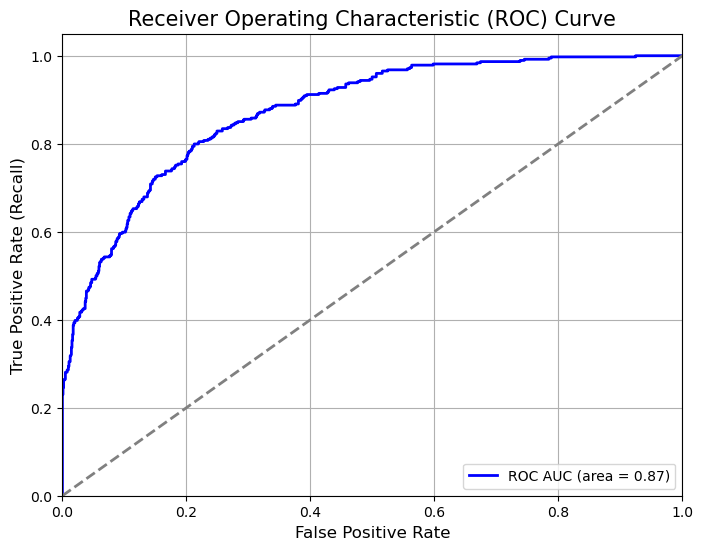

In [1009]:
# Predict probabilities on the test set
y_test_pred_proba = trained_models['Gradient Boosting'].predict_proba(x_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The blue curved line shows how well the model performs compared to the straight diagonal line of randmon guessing.

## Feature Importance Analysis <br>
Let's take a look at why the trained gradient boosting model made the predictions it did by looking at which features are most important in determing churn customers. 

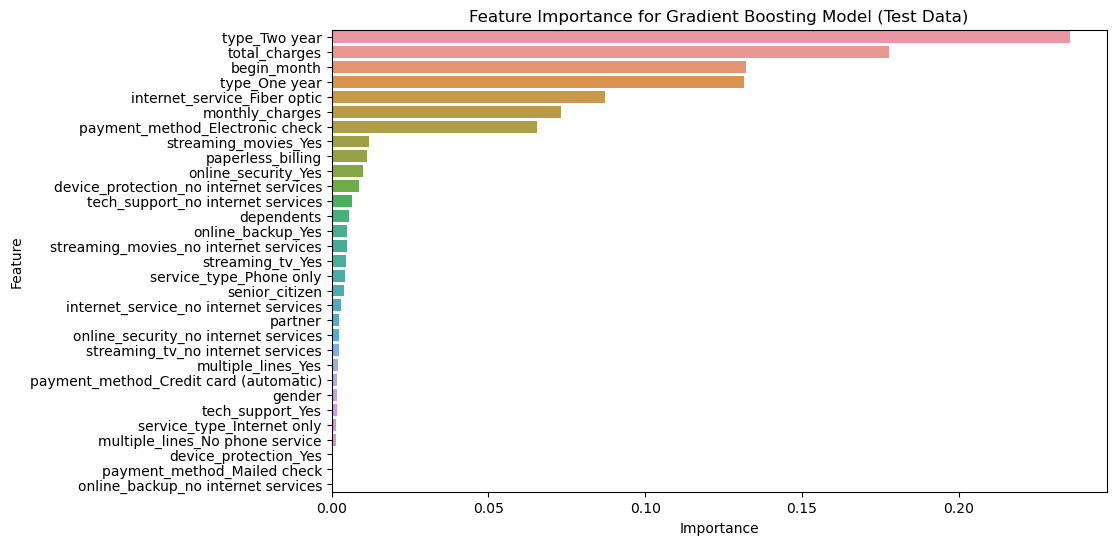

In [1012]:
feature_importances = gb_model.feature_importances_
features = x_test.columns  

# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Gradient Boosting Model (Test Data)')
plt.show()

Our Gradient Boosting Classifier is using 'type' of contract, particularly Two Year contracts as a high indicator of distinguishing churn with an importance rating of over 0.25. Now, remember in our EDA we saw the least amount of churned clients as those with two year contracts and the most churned clients as those with month-to-month contracts. The contradiction here may suggest that those with two year contracts and one year contracts are less likely to churn so our model uses those as strong distinguishing features of non-churners. Also, this feature could be highly interactive with other features such as 'total_charges' suggesting correlation between churners with higher total charges and long term contracts.  
<br>
We also see 'begin_month' as an important feature in determining churn. This suggest we likely have seasonality with churn such as what we saw in our exploratory data analysis that those who likely signed up under promotional offers or seasonal offers have higher churn rates. It would be beneficial to explore more seasonal patterns in future analysis. 
<br>

As we saw in our exploratory analysis and here as well, Fiber Optic Internet is a strong feature in determining churn. Customers with Fiber Optic Internet are more at risk for churning and it would be good to look into the reasonings why. Perhaps it could be poor connection or slow internet speed and it would be beneficial to address potential issues and offer additional tech support and other promotions for Fiber Optic users.
<br>

Higher monthly charges and payment by electronic check are strong indicators of churn. Perhaps offering several payment date options and discounts to those with recurring monthly payments could help reduce churn. 

## Additional Insights --> Hypothesis Testing
Since our model and EDA show contract type and payment method as strong indicators of churn, let's do some hypothesis testing to provide us with stronger, data backed evidence. 

**Contract Type**
<br>
Does contract type (month-to-month vs. long-term) affect customer churn?

**Null Hypothesis (H₀):** There is no significant difference in churn rates between customers with month-to-month contracts and those with 1- or 2-year contracts.
<br>

**Alternative Hypothesis (H₁):** There is a significant difference in churn rates between customers with month-to-month contracts and those with 1- or 2-year contracts.

In [1016]:
# Contract Type Hypothesis Test

# Create new column for month-to-month contracts
merged_df['type_Month-to-month'] = 1 - (merged_df['type_One year'] | merged_df['type_Two year'])

# Split data into two groups
contract_type_monthly = merged_df[merged_df['type_Month-to-month'] == 1]['churned']
contract_type_longterm = merged_df[merged_df['type_Month-to-month'] == 0]['churned'] # Long-term contracts (1 year, 2 years)

# Perform T-Test
t_stat, p_value = stats.ttest_ind(contract_type_monthly, contract_type_longterm)

print(f'T-Test Statistic: {t_stat}')
print(f'P-Value: {p_value}')

# Interpret the result using threshold < 0.05 for balance
if p_value < 0.05:
    print("There is a significant difference in churn rates between monthly and long-term contracts.")
else:
    print("There is no significant difference in churn rates between monthly and long-term contracts.")

T-Test Statistic: 37.17984261635385
P-Value: 1.9917014247247094e-276
There is a significant difference in churn rates between monthly and long-term contracts.


Our hypothesis testing confirms that contract type plays a significant role in customer churn. With a T-test statistic of 37.18 and an extremely low p-value (1.99e-276), we can confidently conclude that there is a substantial difference in churn rates between customers on month-to-month contracts and those on long-term contracts. Customers with month-to-month contracts tend to churn at much higher rates, which is consistent with the insights from our model.

<br>

**Payment Method Hypothesis Testing**
<br>
Does the payment method (e.g., electronic check vs. other methods) affect customer churn?

**Null Hypothesis (H₀):** There is no significant difference in churn rates between customers using different payment methods.

**Alternative Hypothesis (H₁):** There is a significant difference in churn rates between customers using different payment methods.

In [1020]:
# Filter churn based on the payment method
electronic_check_churn = merged_df[merged_df['payment_method_Electronic check'] == 1]['churned']
other_payment_churn = merged_df[merged_df['payment_method_Electronic check'] == 0]['churned']

# Perform T-test between electronic check and other payment methods
t_stat, p_value = stats.ttest_ind(electronic_check_churn, other_payment_churn, equal_var=False)

# Output the results
print(f"T-Test Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in churn rates between electronic check and other payment methods.")
else:
    print("There is no significant difference in churn rates between electronic check and other payment methods.")

T-Test Statistic: 24.288020540713926
P-Value: 3.4896826360532704e-121
There is a significant difference in churn rates between electronic check and other payment methods.


The hypothesis testing confirmed that there is a statistically significant difference in churn rates between customers who use electronic checks as their payment method and those who use other payment methods. The T-Test statistic of 24.29 and the extremely low p-value of 3.49e-121 strongly suggest that electronic check users are much more likely to churn than customers using other methods.

This result highlights the importance of payment methods in predicting churn. Specifically, the use of electronic checks is associated with significantly higher churn rates, which may point to underlying factors such as customer dissatisfaction with this payment option. Further investigation into why electronic check users are more prone to churn could provide valuable insights for improving customer retention strategies.

## Solution Report

**In conclusion,** we were able to perform the majority of the work tasks we set out to accomplish. We cleaned and preprocessed the data by correcting column names, checked for duplicates and handled missing values appropriately. We changed column data types to work for our machine learning models and encoded data as needed. <br>

**Preprocessing** <br>
For the feature engineering we successfully created columns for tenure_months, contract_duration_days, begin_month, and churned. We did not create a column for number of features customer was using but instead categorized each customer by service type. This helped to gain better visual insight into churn and non-churn based on services the customer was signed up for. We can also use these categorized customers to dive deeper into customer habits and length of tenure. <br>

**EDA** <br>
For our exploratory data analysis we looked at how different features correlate with churn and non-churn of customers along with analyzing the rate of churn for each category. We were able to examine the class distributions within each feature. <br>

**Model Development** <br>
We were able to train all of the models set forth in our work plan and looked at how not accounting for class imbalance, adjusting weights for class imbalance, upsampling and downsampling (balancing classes) affected each of the models. We evaluated the models on a validation data set and reviewed F1, Precision, Recall, and ROC AUC scores. We did run into a little hiccup in the first phase of training where our models were performing outstandingly well! Naturally, it was too good to be true and we found a source of data leakage with our contract duration days column and tenure months column that gave our models direct insight into customers that churned! Hah! Once fixed, we narrowed down our models from 4 models to 2, the Random Forest Classifier and the Gradient Boosting Classifier and futher hypertuned the parameters of each model to refine evaluation metrics. From there we got our best performing model, the Gradient Boosting Classifier, and moved it into the Testing phase. <br>

**Final Model** <br>
Our trained Gradient Boosting model achieved a high ROC AUC score of 0.874 on the test dataset - proving that it is capable of identifying customers at risk of churning and distinguishing between non-churners. <br>

**Feature Importance** <br>
With an acceptable model completed, we examined the features that were most important to our model in determining churn. What we concluded was that two-year contracts were the most important feature in determining churn as long-term contract holders have the lowest churn rate to customer proportion. We also saw that total charges were strong indicators for predicting churn. Customers with higher charges were more likely to churn than those with lower rates. This suggests that those customers moved on to companies with better rates and/or contract terms. <br>

**Seasonality** <br>
We also saw that begin month or when a customer signed up for the service had high importance in predicting churn. This is interesting because it shows seasonality in our data. If we dive deeper into trends and seasonality along with historical promotions offered, we can likely gather valuable insights into customer churn patterns and help in future customer retention. <br> 

**Hypothesis Testing** <br>
Knowing what features were important to our model for predicting churn and analyzing the data visually, we went ahead and did some hypothesis testing to backup our findings with concrete data evidence. This provided further confirmation of our key indicators in predicting churn. <br>

**Summary**<br>
All in all it was a very exciting project to work on! We've determined key features in predicting customer churn and have ideas on actionable steps to prevent further churn in the future. We can use this data to dive deeper into seasonal trends of our customers and we also have ideas for additional data collection of customers, such as customer habits. We've found areas where we can improve our services such as looking into Fiber Optic Internet package and offering additional customer support there. Since customers using both internet and phone services have the highest churn rate, we can look at flexible package options, opt-out terms, and flexible payment terms while offering only long term contracts. <br>


I look forward to seeing what we can implement from this data analysis and would be thrilled to find even more impactful data-driven solutions for future endeavors!  :) 